In [1]:
import gc
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
from importlib import reload
from pandas import Timestamp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator, metocean

try:
    map_

except NameError:
    map_ = plot.get_map()

In [2]:
plt.rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [3]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

In [4]:
def plot_observed_and_optimized_tracks(xs, ys, ref_xs, ref_ys):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    ax.plot(xs, ys, color='grey')

    ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')
    
    return fig, ax

In [5]:
def plot_spaghetti(xs, ys, ref_xs, ref_ys):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    for x, y in zip(xs, ys):
        ax.plot(x, y, color='grey')

    ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')
    
    return fig, ax

In [6]:
def pcolor_optimization_results(Cas, Cws, errs, optimal_Ca, optimal_Cw):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    plt.pcolor(Cas - np.mean(np.diff(Cas)) / 2, Cws - np.mean(np.diff(Cws)) / 2 , 
               errs.reshape(len(Cas) - 1, len(Cws) - 1))

    ax.set_xticks(Cas[:-1])
    ax.set_yticks(Cws[:-1])

    ax.scatter(optimal_Ca, optimal_Cw, marker='x', color='white')

    plt.xlabel('Ca')
    plt.ylabel('Cw')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel('RMSE (km)', rotation=90)
    
    return fig, ax

In [21]:
def plot_probabilistic_map(XYZ, xys, ref_xys=None, cbar_step=0.1):
    
    X, Y, Z = XYZ
    x_data, y_data = xys
    ref_x, ref_y  = ref_xys
    
    n_levels = np.arange(0, 1 + cbar_step, cbar_step)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    if ref_xys:
        plt.scatter(ref_x, ref_y, color='black', zorder=1000, label='observed', marker='^')
    
    plt.contourf(X, Y, Z, n_levels, alpha=0.7)

    plt.plot(x_data.T, y_data.T, 'k-',  alpha=0.2, linewidth=1.5)
    plt.plot(np.mean(x_data, 0), np.mean(y_data, 0), 'k', linestyle='--', linewidth=2, label='mean')
      
    plt.legend()

    plt.xlabel('Position (km)')
    plt.ylabel('Position (km)')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel('Probability', rotation=90)
    
    return fig, ax 

In [8]:
def plot_cone(data, labels):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    ts = data['reference'].time.values
    lats = data['reference'].northing.values
    lons = data['reference'].easting.values
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            dat = data[label]
            sim_lats[i, j] = float(dat['northing'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(dat['easting'].interp(time=t, assume_sorted=True).values)
            
    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        mean_lats = np.mean(sim_lats, axis=1)
        mean_lons = np.mean(sim_lons, axis=1) 

        std_lats = np.std(sim_lats, axis=1)
        std_lons = np.std(sim_lons, axis=1)
                
        for j in range(1, 4):
        
            lats_high = []
            lons_high = []
            lats_low = []
            lons_low = []
            
            for i in range(1, len(ts)):

                angle = np.arctan2((mean_lats[i] - mean_lats[i-1]),  (mean_lons[i] - mean_lons[i-1]))
                sigma = j * np.sqrt(std_lats[i]**2 + std_lons[i]**2)
                
                if 90 <= np.rad2deg(angle) <= 180 or -180 <= np.rad2deg(angle) <= -90:
                                    
                    y1 = mean_lats[i] + sigma * np.cos(angle)
                    y2 = mean_lats[i] - sigma * np.cos(angle)
                    x1 = mean_lons[i] - sigma * np.sin(angle)
                    x2 = mean_lons[i] + sigma * np.sin(angle)
                    
                else:
                    
                    y1 = mean_lats[i] + sigma * np.sin(angle)
                    y2 = mean_lats[i] - sigma * np.sin(angle)
                    x1 = mean_lons[i] - sigma * np.cos(angle)
                    x2 = mean_lons[i] + sigma * np.cos(angle)
                    

                if y1 > y2:

                    lats_high.append(y1)
                    lons_high.append(x1)
                    lats_low.append(y2)
                    lons_low.append(x2)

                else:

                    lats_high.append(y2)
                    lons_high.append(x2)
                    lats_low.append(y1)
                    lons_low.append(x1)

            lats_high = np.array(lats_high)
            lons_high = np.array(lons_high)
            lats_low = np.array(lats_low)
            lons_low = np.array(lons_low)

            lons_ = np.append(np.vstack((lons_low, lons_high[::-1])).ravel(), mean_lons[0])
            lats_ = np.append(np.vstack((lats_low, lats_high[::-1])).ravel(), mean_lats[0])
            
            polygon_xys = np.column_stack((lons_, lats_))
            polygon = Polygon(polygon_xys, fill=True, color='k', alpha=0.2, label=fr'$\sigma_{j}$')
            ax.add_patch(polygon)

    plt.plot(mean_lons, mean_lats, label='mean', color='k', alpha=0.8)
    
    ax.scatter(lons, lats, color='k', marker='^', alpha=1, label='observed')
    
    legend = plt.legend()
    
    alphas = [0.8, 0.2, 0.4, 0.6, 1.0]
    
    for i, lh in enumerate(legend.legendHandles):
    
        lh.set_color('k')
        lh.set_alpha(alphas[i])

    plt.xticks()
    plt.yticks()
    
    return fig, ax

In [19]:
def plot_observed_track(xs, ys):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.margins(x=0.2, y=0.4)
    ax.scatter(ref_xs, ref_ys, marker='^', c='black')
    ax.annotate(xy=(ref_xs[0], ref_ys[0]), s='start', xytext=(0, -0.8))
    ax.set_xlabel('Position (km)')
    ax.set_ylabel('Position (km)')
    
    return fig, ax

In [10]:
from mpl_toolkits.basemap import Basemap

In [11]:
def plot_metocean_field(m, tc, field, velocity_field, field_name='ocean'):
    
    if field_name == 'ocean':
        
        field_lons = field.longitude.values
        field_lats = field.latitude.values
        field_times = field.time.values
        cbar_label = 'Current speed (m/s)'
        cmap = 'viridis'
        vmin = 0
        vmax = 0.5
        arrow_scale = 0.05
        index_0 = 0
        index_12 = 11
        index_24 = 23

        num_grid_cells = 20
        
    elif field_name == 'atmosphere':
        
        field_lons = field.longitude.values[:-1]
        field_lats = field.latitude.values
        field_times = field.time.values
        cbar_label = 'Wind speed (m/s)'
        cmap = 'plasma'
        vmin = 0
        vmax = 15
        arrow_scale = 0.8
        index_0 = 0
        index_12 = 3
        index_24 = -1
        
        num_grid_cells = 6
    
    start_x, start_y = m(tc.start_longitude, tc.start_latitude)

    field_xs, field_ys = m(field_lons, field_lats)
    berg_xs, berg_ys = m(tc.ref_lons.values, tc.ref_lats.values)

    field_xs -= start_x
    field_ys -= start_y
    field_xs /= 1000
    field_ys /= 1000

    berg_xs -= start_x
    berg_ys -= start_y
    berg_xs /= 1000
    berg_ys /= 1000

    x_index = np.argmin(abs(field_xs))
    x_index_0 = x_index - num_grid_cells // 2
    x_index_n = x_index + num_grid_cells // 2

    y_index = np.argmin(abs(field_ys))
    y_index_0 = y_index - num_grid_cells // 2
    y_index_n = y_index + num_grid_cells // 2

    velocities = velocity_field.eastward_velocities.values
    us_0 = velocities[index_0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    us_12 = velocities[index_12, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    us_24 = velocities[index_24, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

    velocities = velocity_field.northward_velocities.values
    vs_0 = velocities[index_0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    vs_12 = velocities[index_12, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    vs_24 = velocities[index_24, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

    xs = field_xs[x_index_0 : x_index_n + 1]
    ys = field_ys[y_index_0 : y_index_n + 1]

    xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
    ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 1.7), sharey=True, num='wind')
    
    u = us_0
    v = vs_0
    axs[0].set_xlabel('Position (km)')
    axs[0].set_ylabel('Position (km)')
    for ax, u, v, label in zip(axs, [us_0, us_12, us_24], [vs_0, vs_12, vs_24], ['a)', 'b)', 'c)']):
        ax.set_aspect('equal')
        ax.pcolor(xxs, yys, np.sqrt(u**2 + v**2), cmap=cmap, vmin=vmin, vmax=vmax)
        ax.quiver(xs, ys, u, v, units='xy', angles='xy', color='white', scale=arrow_scale, zorder=1000)
        ax.scatter(berg_xs, berg_ys, marker='^', color='k', s=1)
        ax.set_ylim(-50, 50)
        ax.set_xlim(-50, 50)
        ax.set_xticks([-25, 0, 25])
        ax.set_yticks([-25, 0, 25])
        ax.text(-0.05, 1.15, label, transform=ax.transAxes, va='top', ha='right')

    cm = ax.get_children()[0]
    cbar = fig.colorbar(cm)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(f'{cbar_label}', rotation=90)

    fig.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axs



Day 1




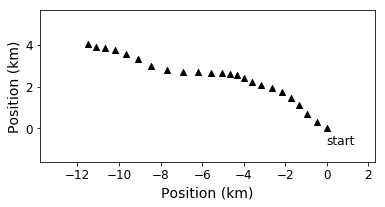

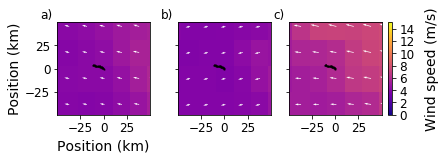

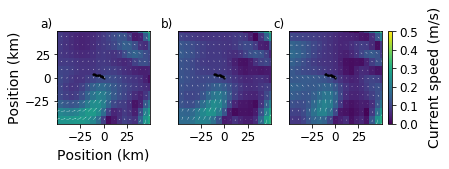

Optimizing Ca and Cw...


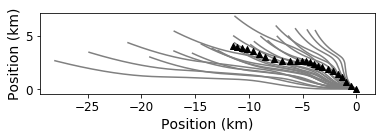

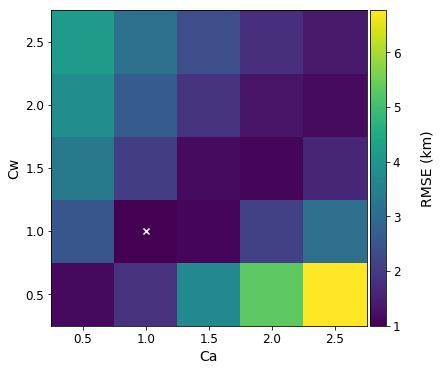

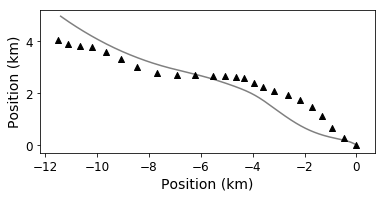

Running ensemble...


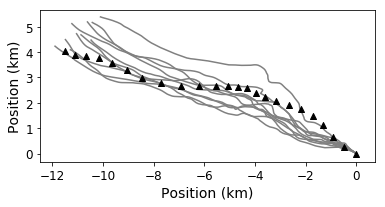

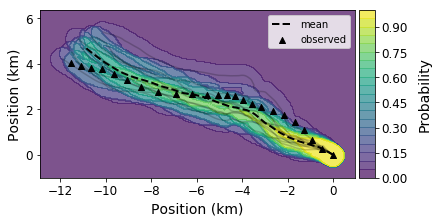

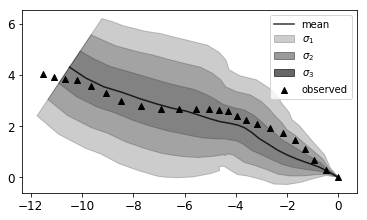

In [22]:
start_day = 1
num_days = 1
days = [day for day in range(start_day, start_day + num_days)]

beacon_id = '90679'  # good berg
#beacon_id = '50519'  # bad berg

df = sd.get_beacon_df(beacon_id=beacon_id)

for day in days:
    
    print(f'\n\nDay {day}\n\n')
    
    if beacon_id == '90679':
        start_index = 816
    elif beacon_id == '50519':
        start_index = 537
    
    start_time = df.DataDate_UTC.values[start_index]
    start_time += np.timedelta64(day - 1, 'D')
    end_time = start_time + np.timedelta64(1, 'D')

    tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

    ref_lats, ref_lons = tc.ref_lats.values, tc.ref_lons.values
    ref_xs, ref_ys = map_(ref_lons, ref_lats)
    ref_xs /= 1000
    ref_ys /= 1000
    ref_x0 = ref_xs[0]
    ref_y0 = ref_ys[0]
    ref_xs -= ref_xs[0]
    ref_ys -= ref_ys[0]
    
    sim_args = tc.time_frame, tc.start_location, tc.start_velocity
    sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
    reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
    sim.results.add_from_dict(reference_data_dict, label='reference')
    sim.testcase = tc
    sim.results.map = map_ 
    
       
    # Plot 1 - Observed drift track

    fig1, ax1 = plot_observed_track(ref_xs, ref_ys)
    plt.show()
        
    
    # Plot 2 - Current and wind velocities

    fig2a, ax2a = plot_metocean_field(map_, tc, sim.atmosphere.data, sim.atmosphere.wind, field_name='atmosphere') #plot_wind(sim, tc)
    plt.show()
    fig2b, ax2b = plot_metocean_field(map_, tc, sim.ocean.data, sim.ocean.current, field_name='ocean')#plot_current(sim, tc)
    plt.show()
                
    print('Optimizing Ca and Cw...')
    
    ref_lats_lons = tc.ref_lats, tc.ref_lons

    Ca, Cw = None, None
    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                      'perturb_current': True, 'perturb_wind': True,
                      'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

    n = 5
    N = n**2

    err_dict = {'Ca': np.zeros(N), 'Cw': np.zeros(N), 'err': np.zeros(N)}

    if beacon_id == '50519' and day == 8:
        
        Cas = np.linspace(0.5, 2.5, n)
        Cws = np.linspace(0.5, 2.5, n)
    
    else:
        
        Cas = np.linspace(0.5, 2.5, n)
        Cws = np.linspace(0.5, 2.5, n)
        
    Ca_mesh, Cw_mesh = np.meshgrid(Cas, Cws)

    sim.results.add_xy_to_existing_dataset('reference')

    all_xs = []
    all_ys = []
    
    ref_xs_ = sim.results.data['reference']['easting']
    ref_ys_ = sim.results.data['reference']['northing']
    
    for i in range(N):                

        label = str(i)
        Ca = Ca_mesh.flatten()[i]
        Cw = Cw_mesh.flatten()[i]
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        
        try:
            sim.run_simulation(label=label, **run_sim_kwargs)
            
        except AssertionError:
            print('Error. Will save results from previous simulation instead.')
            sim.results.data[label] = sim.results.data[str(i-1)]
            
        sim.results.add_xy_to_existing_dataset(label)
        xs = sim.results.data[label]['easting']
        ys = sim.results.data[label]['northing']
        all_xs.append(xs - ref_x0)
        all_ys.append(ys - ref_y0)

        err = calc_mean_error((ys, xs), (ref_ys_, ref_xs_))
        err_dict['Ca'][i] = Ca
        err_dict['Cw'][i] = Cw
        err_dict['err'][i] = err

    index = np.argmin(err_dict['err'][:])
    min_err = err_dict['err'][index]
    optimal_Ca = err_dict['Ca'][index]
    optimal_Cw = err_dict['Cw'][index]
    
    Cas = np.append(Cas, Cas[-1] + np.mean(np.diff(Cas)))
    Cws = np.append(Cws, Cws[-1] + np.mean(np.diff(Cws)))
 
    # Plot 3 - Optimization results

    fig3a, ax3a = plot_spaghetti(all_xs, all_ys, ref_xs, ref_ys)
    plt.show()
    fig3b, ax3b = pcolor_optimization_results(Cas, Cws, err_dict['err'], optimal_Ca, optimal_Cw)
    plt.show()

    xs = sim.results.data[str(index)]['easting'].values - ref_x0
    ys = sim.results.data[str(index)]['northing'].values - ref_y0

    fig3c, ax3c = plot_observed_and_optimized_tracks(xs, ys, ref_xs, ref_ys)
    plt.show()

    labels = [str(i) for i in range(N)]
    for label in labels:
        sim.results.remove_dataset(label)

        
    print('Running ensemble...')
    
    Ca, Cw = optimal_Ca, optimal_Cw
    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

    N = 10

    for i in range(N):

        sim.run_simulation(label=f'{i}', **run_sim_kwargs)
        
    labels = [str(i) for i in range(N)]
    
    all_xs = []
    all_ys = []
    
    for label in labels:

        sim.results.add_xy_to_existing_dataset(label)
        xs = sim.results.data[label]['easting'].values - ref_x0
        ys = sim.results.data[label]['northing'].values - ref_y0
        all_xs.append(xs)
        all_ys.append(ys)

    # Plot 4 - Ensemble spaghetti

    fig4, ax4 = plot_spaghetti(all_xs, all_ys, ref_xs, ref_ys)
    plt.show()


    # Plot 5 - Cones

    rd = sim.results.data

    labels = list(rd.keys())

    x_data = []
    y_data = []

    for i, label in enumerate(labels):
        if not label == 'reference':
            x_data.append(rd[label]['easting'].values - ref_x0)
            y_data.append(rd[label]['northing'].values - ref_y0)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    r = 0.5
    dx = 0.05
    dy = 0.05

    pad = 1 
    xlim_left = np.min(np.append(x_data, ref_xs)) - pad
    xlim_right = np.max(np.append(x_data, ref_xs)) + pad
    ylim_left = np.min(np.append(y_data, ref_ys)) - pad
    ylim_right = np.max(np.append(y_data, ref_ys)) + pad
    X, Y = np.mgrid[xlim_left : xlim_right : dy, ylim_left : ylim_right : dy]
    Z = np.zeros_like(X, dtype='int')

    for x, y in zip(x_data, y_data):
        Z_ = np.zeros_like(Z)
        for x_, y_ in zip(x, y):
            Z_[np.sqrt((X+dx/2-x_)**2 + (Y+dy/2-y_)**2) < r] = 1
        Z += Z_

    # divide by the realizations to come up with a probability
    m = len(labels) - 1
    Z = Z / m

    fig5a, ax5a = plot_probabilistic_map((X, Y, Z), (x_data, y_data), (ref_xs, ref_ys), 0.05)
    plt.show()
    
    data = sim.results.data

    for key in data.keys():

        data[key]['easting'].values -= ref_x0
        data[key]['northing'].values -= ref_y0

    fig5b, ax5b = plot_cone(sim.results.data, labels)
    plt.show()
    
    #ax1.set_title(f'Day {day} - Figure 1')
    fig1.savefig(f'./plots/day{day}_figure1.pdf', bbox_inches='tight')
    #ax2a[0].set_title(f'Day {day} - Figure 2a')
    fig2a.savefig(f'./plots/day{day}_figure2a.pdf', bbox_inches='tight')
    #ax2b[0].set_title(f'Day {day} - Figure 2b')
    fig2b.savefig(f'./plots/day{day}_figure2b.pdf', bbox_inches='tight')
    #ax3a.set_title(f'Day {day} - Figure 3a')
    fig3a.savefig(f'./plots/day{day}_figure3a.pdf', bbox_inches='tight')
    #ax3b.set_title(f'Day {day} - Figure 3b')
    fig3b.savefig(f'./plots/day{day}_figure3b.pdf', bbox_inches='tight')
    #ax3c.set_title(f'Day {day} - Figure 3c')
    fig3c.savefig(f'./plots/day{day}_figure3c.pdf', bbox_inches='tight')
    #ax4.set_title(f'Day {day} - Figure 4')
    fig4.savefig(f'./plots/day{day}_figure4.pdf', bbox_inches='tight')
    #ax5a.set_title(f'Day {day} - Figure 5a')
    fig5a.savefig(f'./plots/day{day}_figure5a.pdf', bbox_inches='tight')
    #ax5b.set_title(f'Day {day} - Figure 5b')
    fig5b.savefig(f'./plots/day{day}_figure5b.pdf', bbox_inches='tight')  
    
    del sim
    del tc
    
    gc.collect()

In [13]:
bob

NameError: name 'bob' is not defined

# Merge PDFs

In [ ]:
files = []

for day in days:
    
    files.append(f'./plots/day{day}_figure1.pdf')
    files.append(f'./plots/day{day}_figure2a.pdf')
    files.append(f'./plots/day{day}_figure2b.pdf')
    files.append(f'./plots/day{day}_figure3a.pdf')
    files.append(f'./plots/day{day}_figure3b.pdf')
    files.append(f'./plots/day{day}_figure3c.pdf')
    files.append(f'./plots/day{day}_figure4.pdf')
    files.append(f'./plots/day{day}_figure5a.pdf')
    files.append(f'./plots/day{day}_figure5b.pdf')
        

In [ ]:
from PyPDF2 import PdfFileMerger

merger = PdfFileMerger()

for file in files:
    merger.append(file)

if beacon_id == '90679':
    merger.write(f"./plots/good_berg_day{days[0]}_to_day{days[-1]}.pdf")
    
elif beacon_id == '50519':
    merger.write(f"./plots/bad_berg_day{days[0]}_to_day{days[-1]}.pdf")


# Inset Map

In [ ]:
df

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

map = Basemap(projection='cyl', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='#7777ff')
map.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map.drawcoastlines()

lons = np.array([-13.7, -10.8, -13.2, -96.8, -7.99, 7.5, -17.3, -3.7])
lats = np.array([9.6, 6.3, 8.5, 32.7, 12.5, 8.9, 14.7, 40.39])
cases = np.array([1971, 7069, 6073, 4, 6, 20, 1, 1])
deaths = np.array([1192, 2964, 1250, 1, 5, 8, 0, 0])
places = np.array(['Guinea', 'Liberia', 'Sierra Leone','United States', 'Mali', 'Nigeria', 'Senegal', 'Spain'])

x, y = map(lons, lats)

map.scatter(x, y, s=cases, c='r', alpha=0.5)

axins = zoomed_inset_axes(ax, 7, loc=1)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=-20,llcrnrlat=3,urcrnrlon=0,urcrnrlat=18, ax=axins)
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(x, y, s=cases/5., c='r', alpha=0.5)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

In [ ]:
lats, lons = df['Latitude'].values, df['Longitude'].values

In [ ]:
plt.plot(lons, lats)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

map_drawn = plot.draw_map(map_)
x, y = map_(lons, lats)

map_drawn.plot(x, y)

In [ ]:
map_kwargs = plot.get_map_kwargs(min(lats), min(lons), max(lats), max(lons), pads=[7, 4, 5, 2])

In [ ]:
map_2 = plot.get_map(**map_kwargs)

In [ ]:
reload(plot)

In [ ]:
big_map = Basemap(projection='cyl',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-56,
                  llcrnrlat=46,
                  urcrnrlon=-48,
                  urcrnrlat=53.5,)




In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

big_map.drawcoastlines()
parallels = big_map.drawparallels(np.arange(0, 90, 2), labels=[1, 0, 0, 0])
meridians = big_map.drawmeridians(np.arange(0., 360., 2.), labels=[0, 0, 0, 1])
x, y = big_map(lons, lats)
big_map.plot(x, y)

ax.annotate(xy=(x[0], y[0]), xytext=(x[0]+0.2, y[0]-0.6), s='Start', 
            arrowprops=dict(facecolor='black', width=0.1, headwidth=4, headlength=4))

ax.annotate(xy=(x[-1], y[-1]), xytext=(x[-1]+0.2, y[-1]-0.6), s='End', 
            arrowprops=dict(facecolor='black', width=0.1, headwidth=4, headlength=4))

axins = zoomed_inset_axes(ax, 1.5, loc=1)
axins.set_xlim(-53, -51)
axins.set_ylim(51, 52)
#plt.xticks(visible=False)
#plt.yticks(visible=False)

inset_map = Basemap(projection='cyl',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-54,
                  llcrnrlat=51.03,
                  urcrnrlon=-51.61,
                  urcrnrlat=51.85,
                  ax=axins)

inset_map.drawcoastlines()
x, y = inset_map(lons, lats)
inset_map.scatter(x, y, s=1)
mark_inset(ax, axins, loc1=2, loc2=4)

plt.show()

In [ ]:
fig.savefig('./plots/good_berg_inset_map.pdf', bbox_inches='tight')

In [ ]:
tc.start_location

In [ ]:
tc2 = test_case.TestCase(beacon_id=beacon_id, start_time=start_time+np.timedelta64(14, 'D'), 
                         end_time=start_time+np.timedelta64(15, 'D'))

In [ ]:
tc2.start_location

In [ ]:
plt.plot(tc2.ref_lons.values, tc2.ref_lats.values)